# TP 1: Parcours des protons dans la matière

In [103]:
# On fait quelques import importants:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import scipy as sp
from scipy import constants as phys_const

## Question 1

Selon l'article au lien suivant:

$$\href{https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4407514/}{https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4407514/}$$

Nous avons que l'énergie ($T$) va de 1 Mev jusqu'à 250 Mev.

Avec la relativité restreinte, nous avons que

$$T = (\gamma - 1) m_0 c^2$$

alors,

$$\implies \gamma = \frac{T}{m_0 c^2} + 1 $$

De plus, selon la relativité restreinte encore:

$$\gamma = \frac{1}{\sqrt{1 - \beta^2}}$$

$$\implies \beta = \sqrt{1 - \frac{1}{\gamma^2}} $$

## Question 2

Pour commencer, puisque nous cherchons une densité d'électron, celle-ci correspond donc au nombre d'électron par gramme multiplié par la densité volumique.

$$n_e = N_e\rho $$

Puisqu'il y a plusieurs atomes, avec des proportions différentes, nous devons donc considérer la masse molaire et 
le nombre d'avogadro ainsi que les proportions afin de déterminer le nombre d'électron par gramme

$$N_e = \sum_i\frac{ Z_i \xi_i N_0}{M_i}$$

où $Z_i$ est la nombre atomique de l'élément i,
   $\xi_i$ est l'abondance relative de l'élément i,
   $N_0$ est le nombre d'avogadro,
   $M_i$ est la masse molaire de l'élément i.



Ici, on déclare une classe *Material*.

In [104]:
class Material:
    
    _Z_to_molar_mass: dict = {
    #   Z: molar mass [g/mol]
        1: 1.008,
        6: 12.011,
        7: 14.007,
        8: 15.999,
        12: 24.305,
        15: 30.974,
        16: 32.06,
        20: 40.078,
        30: 65.38
    }
    
    # composition icrp, [icrp : = cortical bone]
    # source du NIST: https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=120}{https://physics.nist.gov/cgi-bin/Star/compos.pl?refer=ap&matno=120
    _density_icrp: float = 1.85  # [g/cm^3]
    _composition_icrp: dict = {
    #   Z: abondance relative
        1: 0.047234,
        6: 0.144330,
        7: 0.041990,
        8: 0.446096,
        12: 0.002200,
        15: 0.104970,
        16: 0.003150,
        20: 0.209930,
        30: 0.000100
    }
    
    _density_water: float = 1.00  # [g/cm^3]
    _composition_water: dict = {
    #   Z: abondance relative
        1: 0.111894,
        8: 0.888106
    }
    
    _compositions: dict = {
        "icrp": _composition_icrp,
        "water": _composition_water,
        "H2O": _composition_water
    }
    
    _densities: dict = {
        "icrp": _density_icrp,
        "water": _density_water,
        "H2O": _density_water
    }
        
    _mean_excitation_energies: dict = {
        "icrp": 106.4,
        "water": 75.0,
        "H2O": 75.0
    }
    
    def __init__(self, name: str, composition: dict = None, density: float = None,
                 mean_excitaiton_energy: float = None):
        
        self._name: str = name
        
        # setting the _composition attribute
        if composition is not None:
            self._composition = composition
        elif name in Material._compositions:
            self._composition = Material._compositions[name]
        else:
            assert "This material is unknown, please set the composition dict parameter."
        
        # setting the _density attribute
        if density is not None:
            self._density = density
        elif name in Material._densities:
            self._density = Material._densities[name]
        else:
            assert "This material is unknown, please set the density parameter."
        
        # setting the _mean_excitation_energy attribute
        if mean_excitaiton_energy is not None:
            self._mean_excitation_energy = mean_excitaiton_energy
        elif name in Material._densities:
            self._mean_excitation_energy = Material._mean_excitation_energies[name]
        else:
            assert "This material is unknown, please set the mean_excitation_energy parameter."
        
        # Updating the Material _compostions
        if name not in Material._compositions:
            Material._compositions[name] = composition
        
        # Updating the Material _densities
        if name not in Material._densities:
            Material._densities[name] = density
        
        # Updating the Material _mean_excitation_energies
        if name not in Material._mean_excitation_energies:
            Material._mean_excitation_energies[name] = mean_excitaiton_energy
    
    @property
    def Density(self) -> float:
        return self._density
    
    @property
    def Name(self) -> str:
        return self._name
    
    def getName(self) -> str:
        return self._name
    
    def setName(self, new_name: str):
        assert new_name in self._compositions
        self._name = new_name
        self._composition = self._compositions[new_name]
        self._density = self._densities[new_name]
        self._mean_excitation_energy = self._mean_excitation_energies[new_name]
    
    def getNe(self) -> float:
        N_0: float = phys_const.Avogadro
        return N_0*np.sum([(Z_i*xi_i)/Material._Z_to_molar_mass[Z_i] 
                           for Z_i, xi_i in self._composition.items()])

    def getElectronicDensity(self) -> float:
        return self.getNe()*self._density
    
    @staticmethod
    def getGamma(T):
        m_p = phys_const.physical_constants["proton mass energy equivalent in MeV"][0]
        return (T/(m_p)) + 1
    
    @staticmethod
    def getBeta(T):
        return np.sqrt(1 - Material.getGamma(T)**(-2))
    
    @staticmethod
    def getTeMax(T):
        m_e = phys_const.physical_constants["electron mass energy equivalent in MeV"][0]
        m_p = phys_const.physical_constants["proton mass energy equivalent in MeV"][0]
        rap_me_mp = m_e/m_p
        num = 2*m_e*(Material.getGamma(T)**2 - 1)
        denum = 1 + 2*Material.getGamma(T)*rap_me_mp + rap_me_mp**2
        return num/denum
    
    def getScol(self, T):
        r_e: float = phys_const.physical_constants["classical electron radius"][0] * 100 # [cm]
        m_e = phys_const.physical_constants["electron mass energy equivalent in MeV"][0]
        gamma = self.getGamma(T)
        beta = self.getBeta(T)
        n_e = self.getElectronicDensity()
        TeMax = self.getTeMax(T)
        I = self._mean_excitation_energy/ 1e6  # [MeV]
        
        coeff0 = 2*np.pi*(r_e**2)*m_e*n_e*(beta**(-2))
        ln_arg = (2*m_e*(beta**2)*(gamma**2)*TeMax)/(I**2)
        return coeff0*(np.log(ln_arg) - 2*(beta**2))

In [105]:
icrp = Material(name="icrp")
water = Material(name="water")

materials = [icrp, water]

On affiche les donnée calculé avec le présent modèle.

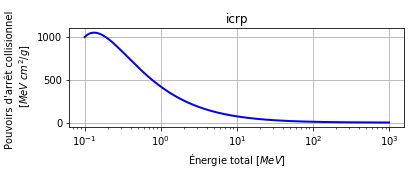

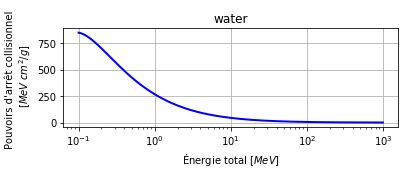

In [106]:
# We plot the Scol of the materials.

for material in materials:
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    
    T = np.linspace(1e-1, 1e3, 1_000_000)

    line, = ax.plot(T, material.getScol(T), color='blue', lw=2)
    ax.set_xscale('log')
    ax.set_title(material.getName())
    ax.set_xlabel("Énergie total [$MeV$]")
    ax.set_ylabel("Pouvoirs d'arrêt collisionnel \n [$MeV \; cm^2/g$]")

    plt.grid()
    plt.show()

Plotting the NIST Data for comparison

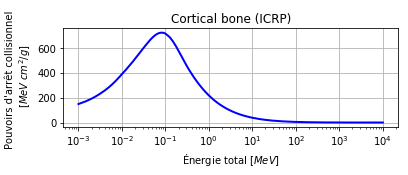

In [107]:
df_icrp = pandas.read_csv(f"{os.getcwd()}//Data/NIST_DATA_ICRP.txt", delimiter='|', header=2)
df_icrp = df_icrp.drop(columns=df_icrp.columns[-1])
data_icrp = df_icrp.to_numpy()


fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(data_icrp[:, 0], data_icrp[:, 1], color='blue', lw=2)
ax.set_xscale('log')
ax.set_title("Cortical bone (ICRP)")
ax.set_xlabel("Énergie total [$MeV$]")
ax.set_ylabel("Pouvoirs d'arrêt collisionnel \n [$MeV \; cm^2/g$]")

plt.grid()
plt.show()

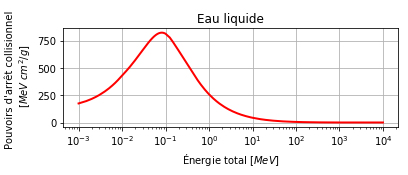

In [108]:
df_water = pandas.read_csv(f"{os.getcwd()}//Data/NIST_DATA_LIQUID_WATER.txt", delimiter='|', header=2)
df_water = df_water.drop(columns=df_water.columns[-1])
data_water = df_water.to_numpy()


fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

line, = ax.plot(data_water[:, 0], data_water[:, 1], color='red', lw=2)
ax.set_xscale('log')
ax.set_title("Eau liquide")
ax.set_xlabel("Énergie total [$MeV$]")
ax.set_ylabel("Pouvoirs d'arrêt collisionnel \n [$MeV \; cm^2/g$]")

plt.grid()
plt.show()

Les données semblent bien correspondent dans l'intervalle d'énergie $[3, \infty)$ MeV.

# Portée des protons dans la matière

## 3. Analyse dimensionnelle de R_CDSA

Voici l'équation:

$$R_{CSDA} = \int_{0}^{T_i} \frac{d T'}{S_{col}/\rho}$$

On peut voir sur le site du NIST que les unités de $R_{CSDA}$  sont des $[g/cm^2]$. À droite de l'équation, on intègre sur des MeV des 
$$\frac{[g/cm^3]}{[cm]^2 * [MeV] * [cm^{-3}]}$$
$$ = \frac{[g]}{[cm]^2 * [MeV]} $$

Ce qui nous donne les unités $[g/cm^2]$ à droite de l'équation, ce qui correspond bel et bien aux unités de $R_{CSDA}$.

## 4.

Comme on peut voir dans les graphique précédent (Il faudrait supperposer le graphique du modèle sur le graphique du NIST) les courbes correspondent. Montrer que la tendance des courbes sont bonnes et logique ainsi de comparer avec les données du NIST.

## 5. Justifiez la nécessité d’employer une méthode numérique pour calculer la portée des protons.

# Détermination de R_CSDA par intégration numérique

In [116]:
class MathFunction:
    def __init__(self, func):
        self.function = func
        
        self.integration_methods: dict = {
            "auto": self.adaptative_trapezoid_integration,
            "trapezoid": self.trapezoid_integration,
            "adapdative_trapezoid": self.adaptative_trapezoid_integration
        }
    
    def integrate(self, method: str = "auto", **kwargs):
        assert method in self.integration_methods
        return self.integration_methods[method](**kwargs)
    
    def adaptative_trapezoid_integration(self, **kwargs) -> (float, float):
        assert "bounds" in kwargs
        bounds = kwargs["bounds"]
        error_target = kwargs.get("error_target", 1e-9)
        max_iteration = kwargs.get("max_iteration", 100)
        
        memory: dict = {
            "I_i": self.trapezoid_integration(bounds=bounds, N=1),
            "I_i+1": self.trapezoid_integration(bounds=bounds, N=2)
        }
        
        error: float = np.inf
        for i in range(1, max_iteration+1):
            if error <= error_target:
                break
            error = np.abs((memory["I_i+1"] - memory["I_i"])/3)
            
            memory["I_i"] = memory["I_i+1"]
            memory["I_i+1"] = self.trapezoid_integration(bounds=bounds, N=2**(i+1))
            
        return memory["I_i+1"], error
    
    def trapezoid_integration(self, **kwargs) -> float:
        assert "bounds" in kwargs and "N" in kwargs
        bounds = kwargs["bounds"]
        N = kwargs["N"]
        
        X = np.linspace(bounds[0], bounds[1], N+1)
        Y = self.function(X)
        Y_d = Y[1:]
        Y_g = Y[:-1]
        h = (bounds[1] - bounds[0])/N
        return (h/2) * np.sum(Y_g + Y_d)

In [117]:
def R_CSDA(self):
    integrand = MathFunction(lambda T: self.Density/self.getScol(T))
    return integrand.integrate(method="adapdative_trapezoid", bounds=[0.1, 100])

Material.R_CSDA = R_CSDA  # Adding the R_CSDA function to Material class as a new method

icrp_Rcsda = icrp.R_CSDA()
water_Rcsda = water.R_CSDA()

print(f"Porté des protons dans le matériel '{icrp.Name}': {icrp_Rcsda[0]/icrp.Density} [cm], error: {icrp_Rcsda[1]} [cm]")
print(f"Porté des protons dans le matériel '{water.Name}': {water_Rcsda[0]/water.Density} [cm], error: {water_Rcsda[1]} [cm]")

Porté des protons dans le matériel 'icrp': 4.662130028006096 [cm], error: 4.1185603076125216e-10 [cm]
Porté des protons dans le matériel 'water': 7.7108110649485235 [cm], error: 8.799769801726143e-10 [cm]


## 7. 


$$  $$

## 9.

In [120]:
def gaussxq(self, N) -> (float, float):
    # Initial approximation to roots of the Legendre polynomial
    a = np.linspace(3,4*N-1,N)/(4*N+2)
    x = np.cos(np.pi*a+1/(8*N*N*np.tan(a)))

    # Find roots using Newton's method
    epsilon = 1e-15
    delta = 1.0
    while delta > epsilon:
        p0 = np.ones(N,float)
        p1 = np.copy(x)
        for k in range(1,N):
            p0,p1 = p1,((2*k+1)*x*p1-k*p0)/(k+1)
        
        dp = (N+1)*(p0-x*p1)/(1-x*x)
        dx = p1/dp
        x -= dx
        delta = max(abs(dx))

    # Calculate the weights
    w = 2*(N+1)*(N+1)/(N*N*(1-x*x)*dp*dp)

    return x, w

MathFunction.gaussxq = gaussxq

def gaussian_quadrature_integration(self, **kwargs) -> float:
    assert "bounds" in kwargs and "N" in kwargs
    bounds = kwargs["bounds"]
    N = kwargs["N"]
    [a, b] = bounds
    
    # Calculate the sample points ans weights, then map them
    # to the required integration domain
    x, w = self.gaussxq(N)
    xp = 0.5*(b-a)*x + 0.5*(b+a)
    wp = 0.5*(b-a)*w
    
    # perform the integration
    s: float = float()
    for k in range(N):
        s += wp[k]*self.function(xp[k])
    
    return s

MathFunction.gaussian_quadrature_integration = gaussian_quadrature_integration

def gaussian_quad_find_N(self, **kwargs) -> int:
    N: int = 100
    return N

MathFunction.gaussian_quad_find_N = gaussian_quad_find_N

def gaussian_quadrature(self, **kwargs) -> float:
    assert "bounds" in kwargs
    N: int = self.gaussian_quad_find_N(**kwargs)
    kwargs["N"] = N
    return self.gaussian_quadrature_integration(self, **kwargs)

MathFunction.gaussian_quadrature = gaussian_quadrature

def newInit(self, func):
    self.function = func

    self.integration_methods: dict = {
        "auto": self.adaptative_trapezoid_integration,
        "trapezoid": self.trapezoid_integration,
        "adapdative_trapezoid": self.adaptative_trapezoid_integration,
        "gaussian_quadrature": gaussian_quadrature
    }

MathFunction.__init__ = newInit

In [ ]:
proton_energies = np.random.normal(240, 3, 10_000)

